# Yellow Sea Microplastic Data

Research Paper with Data: https://www.sciencedirect.com/science/article/pii/S2352340919303427?via%3Dihub#sec2


data was collected June 15–30, 2016

### Import Required Libraries

In [1]:
import os
import json
import requests
from pprint import pprint
from datetime import date, timedelta, datetime
from io import BytesIO
from collections import Counter, OrderedDict

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

import xgboost as xgb

import earthaccess

### Load in downloaded data

In [2]:
# load the microplastic count per fish data
data_path = "/Users/ds/mids/datasci210/data/ScienceDirect_files_17Oct2024_08-09-12.097/1-s2.0-S2352340919303427-mmc2.xlsx"
df1 = pd.read_excel(data_path, header=1, usecols='C:H', names=['station','latin','length_cm','weight_g', 'shape','mp_length_um'])
print(df1.describe(),'\n')
print(df1.info())

        length_cm    weight_g  mp_length_um
count  546.000000  546.000000    546.000000
mean    10.401154   10.565143    940.845948
std      3.672895    9.983822   1012.471797
min      5.640000    1.046000     15.942263
25%      8.020000    3.834500    224.089271
50%      9.550000    8.677500    502.413360
75%     11.830000   13.217750   1292.015992
max     41.400000   86.647000   4739.634818 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   station       546 non-null    object 
 1   latin         546 non-null    object 
 2   length_cm     546 non-null    float64
 3   weight_g      546 non-null    float64
 4   shape         546 non-null    object 
 5   mp_length_um  546 non-null    float64
dtypes: float64(3), object(3)
memory usage: 25.7+ KB
None


In [3]:
# load lat lon data for each station
data_path = "/Users/ds/mids/datasci210/data/ScienceDirect_files_17Oct2024_08-09-12.097/1-s2.0-S2352340919303427-mmc3.xlsx"
df2 = pd.read_excel(data_path, sheet_name='Figure 2',names=['station','lat','lon','avg_mp_per_fish'])
print(df2.describe(),'\n')
print(df2.info())

             lat         lon  avg_mp_per_fish
count  53.000000   53.000000        53.000000
mean   34.429239  123.028607         0.448491
std     2.227657    1.030078         0.221154
min    31.481217  120.710233         0.130000
25%    32.517917  122.230900         0.300000
50%    34.009000  123.024250         0.400000
75%    35.993700  123.942450         0.500000
max    38.820983  124.818383         1.400000 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   station          53 non-null     object 
 1   lat              53 non-null     float64
 2   lon              53 non-null     float64
 3   avg_mp_per_fish  53 non-null     float64
dtypes: float64(3), object(1)
memory usage: 1.8+ KB
None


In [4]:
# combine data on the station id for mapping to cygnss
df_merged = pd.merge(df1, df2, how='left', on='station')
df_merged = df_merged.drop('avg_mp_per_fish',axis=1)
print(df_merged.describe(),'\n')
print(df_merged.info())

# assign main df for processing
df = df_merged

        length_cm    weight_g  mp_length_um         lat         lon
count  546.000000  546.000000    546.000000  546.000000  546.000000
mean    10.401154   10.565143    940.845948   34.528023  123.018390
std      3.672895    9.983822   1012.471797    2.205539    1.058447
min      5.640000    1.046000     15.942263   31.481217  120.710233
25%      8.020000    3.834500    224.089271   32.660275  122.230900
50%      9.550000    8.677500    502.413360   34.005467  123.032025
75%     11.830000   13.217750   1292.015992   36.022787  123.942450
max     41.400000   86.647000   4739.634818   38.820983  124.818383 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   station       546 non-null    object 
 1   latin         546 non-null    object 
 2   length_cm     546 non-null    float64
 3   weight_g      546 non-null    float64
 4   shape         546 n

In [5]:
# calculate number of microplastics per fish using length and weight pairs as unique ID for a fish
# --> paper says that there should be 444 unique fish samples
df_grouped = df.groupby(['length_cm','weight_g'])

# get the full row each unique fish
df_grouped_last = df_grouped.last()

# create columnn for the number of microplastics found in each fish
df_grouped_last['mp_counts'] = df_grouped['latin'].count()

# remove station, shape, mp length columns
df_grouped_last = df_grouped_last.drop(['station','shape','mp_length_um'], axis=1)

# reassign modified dataframe to initial variable
df_grouped = df_grouped_last
print(df_grouped)

                                      latin        lat         lon  mp_counts
length_cm weight_g                                                           
5.64      2.281             Liparis tanakae  36.506817  122.987883          1
5.80      1.956             Liparis tanakae  37.008500  123.531667          2
6.04      1.046         Engraulis japonicus  33.511000  122.213033          1
6.14      1.905             Liparis tanakae  34.502833  123.796067          1
          2.049             Liparis tanakae  38.003533  121.710117          2
...                                     ...        ...         ...        ...
27.66     7.293     Eupleurogramms muticus   36.472383  122.022783          1
33.18     15.143    Eupleurogramms muticus   36.472383  122.022783          1
37.68     23.727    Eupleurogramms muticus   32.517917  123.039800          1
37.92     23.588    Eupleurogramms muticus   32.517917  123.039800          1
41.40     28.895    Eupleurogramms muticus   32.517917  123.0398

In [6]:
df_grouped

latin        lat         lon  mp_counts
length_cm weight_g                                                           
5.64      2.281             Liparis tanakae  36.506817  122.987883          1
5.80      1.956             Liparis tanakae  37.008500  123.531667          2
6.04      1.046         Engraulis japonicus  33.511000  122.213033          1
6.14      1.905             Liparis tanakae  34.502833  123.796067          1
          2.049             Liparis tanakae  38.003533  121.710117          2
...                                     ...        ...         ...        ...
27.66     7.293     Eupleurogramms muticus   36.472383  122.022783          1
33.18     15.143    Eupleurogramms muticus   36.472383  122.022783          1
37.68     23.727    Eupleurogramms muticus   32.517917  123.039800          1
37.92     23.588    Eupleurogramms muticus   32.517917  123.039800          1
41.40     28.895    Eupleurogramms muticus   32.517917  123.039800          1

[444 rows x 4 columns]

### Split dataframe into train-val-test

In [7]:
# assign features and target
X = df_grouped[list(df_grouped.columns[:-1])].reset_index()
y = df_grouped['mp_counts'].reset_index()

# initialize sklearn encoder
encoder = OrdinalEncoder()

# perform encoding on the latin name feature
X['latin'] = encoder.fit_transform(X[['latin']])

# intialize standard scaler for data transformation
scaler = StandardScaler()

# Standardize the features and target
X = scaler.fit_transform(X.reset_index())
y = scaler.fit_transform(y.reset_index())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# split test into val-test
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

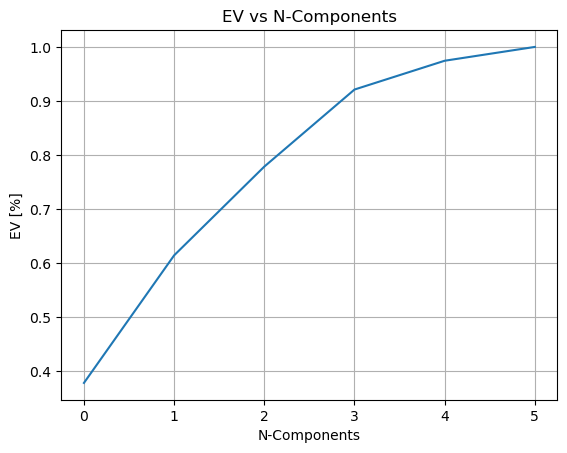

In [9]:
# Apply PCA
pca = PCA(n_components=min(X_train.shape))  
X_train_pca = pca.fit_transform(X_train)

# see how much variance each component explains
explained_variance = pca.explained_variance_ratio_

# generate figure to show EV
plt.plot(np.cumsum(explained_variance))
plt.title('EV vs N-Components')
plt.ylabel('EV [%]')
plt.xlabel('N-Components')
plt.grid()
plt.show()

### Define function for pulling satellite data

In [10]:
def getSatelliteData(input_date):
    '''
    perform url request to earthdata cmr for CYGNSS, RSSSMAP, and GHRSST data and return the data
    from the most recent 30 days 
    '''
    
    if not isinstance(input_date, date):
        raise TypeError("This function only accepts date objects.")
    
    # define earthdata cmr url
    earthdata_url = 'https://cmr.earthdata.nasa.gov/search/granules.umm_json?collection_concept_id='
    
    # login to earthdata portal to get credentials
    auth = earthaccess.login()
    
    # define concept ids for desired data
    cygnss_concept_id = 'C2893924134-POCLOUD' # microplastic
    rsssmap_concept_id = 'C2832227567-POCLOUD' # sea surface salinity
    ghrsst_concept_id = 'C2600797908-POCLOUD' # sea surface temperature

    # define time range to search [days]
    temporal_range = 30
    
    # calculate start data from input date
    start_date = (input_date - timedelta(days=temporal_range)).strftime('%Y-%m-%dT%H:%M:%SZ')
    
    # format and combine start date and input date for url query parameter
    temporal_query = start_date + ',' + input_date.strftime('%Y-%m-%dT%H:%M:%SZ')

    # send search request to cmr with additional params
    cygnss_r = requests.get(earthdata_url + cygnss_concept_id + '&temporal=' + temporal_query + '&pageSize=1000')
    ghrsst_r = requests.get(earthdata_url + ghrsst_concept_id + '&temporal=' + temporal_query + '&pageSize=1000')
    
    # re-define time range [days] to search for RSSSMAP data because it is an 8 day average
    temporal_range = 30 - 4
    
    # calculate start data from input date
    start_date = (input_date - timedelta(days=temporal_range)).strftime('%Y-%m-%dT%H:%M:%SZ')
    
    # format and combine start date and input date for url query parameter
    temporal_query = start_date + ',' + input_date.strftime('%Y-%m-%dT%H:%M:%SZ')
    
    rsssmap_r = requests.get(earthdata_url + rsssmap_concept_id + '&temporal=' + temporal_query + '&pageSize=1000')
    
    # aggregate data responses for pulling urls
    data_r = [('CYGNSS',cygnss_r), ('RSSSMAP',rsssmap_r), ('GHRSST',ghrsst_r)]
    
    # if the resonse is good, parse through and print it
    data_files = {key : [] for key, _ in data_r}
    for data_name, r in data_r:
        if r.ok:
            response_body = r.json()
            for itm in response_body['items']:
                for urls in itm['umm']['RelatedUrls']:
                    if 'OPeNDAP' in urls['Description']:
                        data_files[data_name].append(urls['URL'])
                    
    return data_files
    

### Get satellite data for Month of June 2016

In [14]:
data_collection_date = date(2016, 7, 1)
data_collection_date = date(2024, 10, 14)

In [15]:
satellite_files = getSatelliteData(data_collection_date)
pprint(satellite_files)

{'CYGNSS': ['https://opendap.earthdata.nasa.gov/collections/C2893924134-POCLOUD/granules/cyg.ddmi.s20240914-120000-e20240914-120000.l3.grid-microplastic.a32.d33',
            'https://opendap.earthdata.nasa.gov/collections/C2893924134-POCLOUD/granules/cyg.ddmi.s20240915-120000-e20240915-120000.l3.grid-microplastic.a32.d33',
            'https://opendap.earthdata.nasa.gov/collections/C2893924134-POCLOUD/granules/cyg.ddmi.s20240916-120000-e20240916-120000.l3.grid-microplastic.a32.d33',
            'https://opendap.earthdata.nasa.gov/collections/C2893924134-POCLOUD/granules/cyg.ddmi.s20240917-120000-e20240917-120000.l3.grid-microplastic.a32.d33',
            'https://opendap.earthdata.nasa.gov/collections/C2893924134-POCLOUD/granules/cyg.ddmi.s20240918-120000-e20240918-120000.l3.grid-microplastic.a32.d33',
            'https://opendap.earthdata.nasa.gov/collections/C2893924134-POCLOUD/granules/cyg.ddmi.s20240919-120000-e20240919-120000.l3.grid-microplastic.a32.d33',
            'https://o

In [16]:
# takes ~5 minutes to load in a months worth of data
tic = datetime.now()
mp_satellite_data = [file.replace('https','dap4') for file in satellite_files['CYGNSS']]
mp_sat_data = xr.open_mfdataset(mp_satellite_data, combine='by_coords', engine='pydap')
print(f'Loading satellite data took {(datetime.now() - tic).total_seconds()} seconds\n')

Loading satellite data took 470.855019 seconds



### Quick look at local region for data

In [18]:
# # get geographic bounding box for the data
# lat_max, lon_max, lat_min, lon_min = (X_train[['lat','lon']].agg(['max','min']).to_numpy().flatten())

# # assign subregion from all satellite coverage to localized area of data
# region = mp_sat_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
# print(region)

### Quick XGBoost Model on Tabular Data

In [19]:
# Initialize the XGBoost regressor
model = xgb.XGBRegressor(eval_metric='rmse')

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_val)

# # Evaluate the model's performance
mse = mean_squared_error(y_val, y_pred)

print(f"Mean Squared Error: {mse:.6f}")

Mean Squared Error: 0.111876


#### CV GridSearch for best model

In [20]:
# Define a parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'n_estimators': [50,100, 200],
    'subsample': [0.8, 1.0],
}

# Initialize the regressor
gs_model = xgb.XGBRegressor(eval_metric='rmse')

# generate and configure grid search object
grid_search = GridSearchCV(
                           estimator=gs_model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=3, 
                           verbose=1
                          )

# perform grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
print(f"Best parameters: {grid_search.best_params_}")

# generate model with best parameters from grid search
model = xgb.XGBRegressor(**grid_search.best_params_, eval_metric='rmse')

# fit best model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_val)

# Evaluate the model's performance
mse = mean_squared_error(y_val, y_pred)
print(f"Mean Squared Error: {mse:.6f}")

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Mean Squared Error: 0.098873


#### Retrain Best Model from GridSearch

[0]	validation_0-rmse:0.89244	validation_1-rmse:1.14111
[1]	validation_0-rmse:0.82852	validation_1-rmse:1.06025
[2]	validation_0-rmse:0.77065	validation_1-rmse:0.98674
[3]	validation_0-rmse:0.71832	validation_1-rmse:0.92062
[4]	validation_0-rmse:0.67097	validation_1-rmse:0.86072
[5]	validation_0-rmse:0.62811	validation_1-rmse:0.80586
[6]	validation_0-rmse:0.58939	validation_1-rmse:0.75651
[7]	validation_0-rmse:0.55441	validation_1-rmse:0.71239
[8]	validation_0-rmse:0.52271	validation_1-rmse:0.67164
[9]	validation_0-rmse:0.49409	validation_1-rmse:0.63307
[10]	validation_0-rmse:0.46813	validation_1-rmse:0.59768
[11]	validation_0-rmse:0.44455	validation_1-rmse:0.56506
[12]	validation_0-rmse:0.42337	validation_1-rmse:0.53631
[13]	validation_0-rmse:0.40429	validation_1-rmse:0.50979
[14]	validation_0-rmse:0.38710	validation_1-rmse:0.48555
[15]	validation_0-rmse:0.37146	validation_1-rmse:0.46425
[16]	validation_0-rmse:0.35736	validation_1-rmse:0.44483
[17]	validation_0-rmse:0.34452	validation

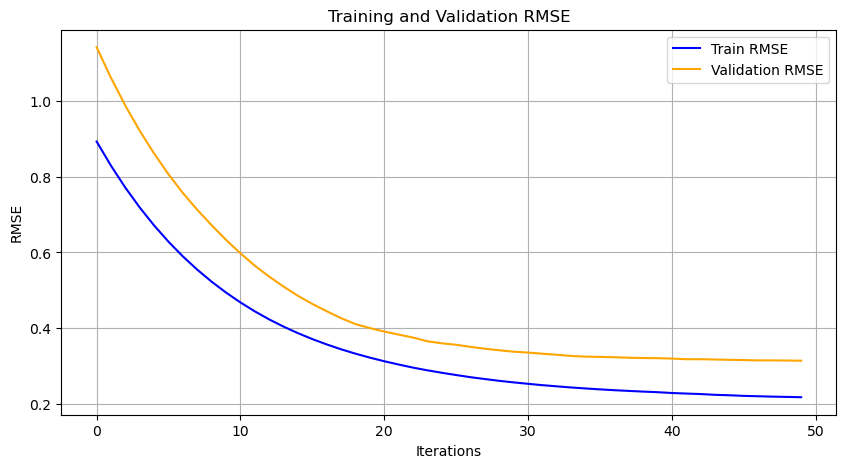

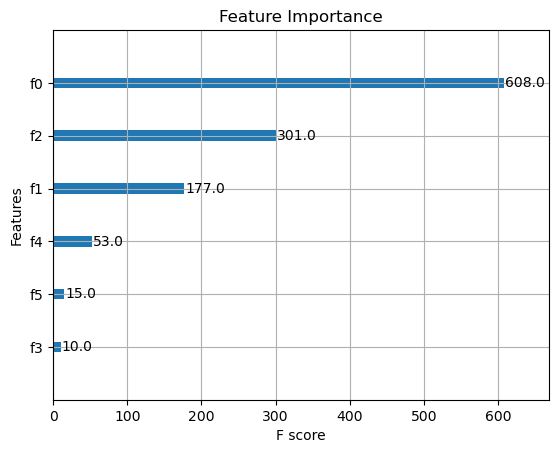

In [21]:
# Refit the best model with early stopping after grid search
model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val,y_val)], verbose=True)

# Make predictions on the validation set
y_pred = model.predict(X_val)

# Extract training and validation RMSE from the model
results = model.evals_result()
train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']

# Plot RMSE for training and validation sets over iterations
plt.figure(figsize=(10, 5))
plt.plot(train_rmse, label='Train RMSE', color='blue')
plt.plot(val_rmse, label='Validation RMSE', color='orange')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()
plt.grid()
plt.show()

# Plot feature importance
xgb.plot_importance(model)
plt.title("Feature Importance")
plt.show()